# 1. TRAINING:

In [25]:
# Import necessary libraries
import joblib
from huggingface_hub import login, HfApi
from huggingface_hub import hf_hub_download


# Set your repository name
repo_name = "davnas/library_model"  # Replace with your desired repository name

## 1.1.Download Tables

In [26]:
!pip install -q matplotlib datasets joblib


<ipython-input-27-4416368bd62d>:21: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_seating_resampled = df_seating.resample('10T').mean().interpolate(method='linear').round().astype(int)


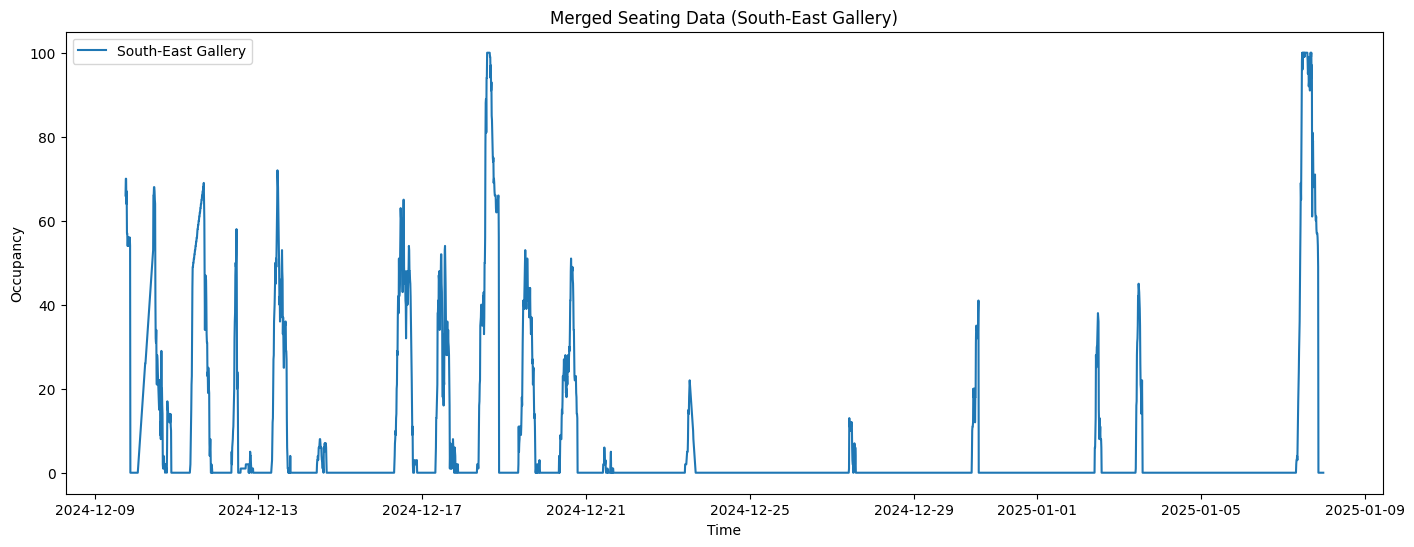

In [27]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from datetime import timedelta
# Step 1: Load the seating dataset
repo_name_seating = "davnas/occupancy_perc"
hf_dataset_seating = load_dataset(repo_name_seating)

# Combine all splits into a single DataFrame with appropriate data types
df_seating = pd.concat(
    [split.to_pandas().astype({'KTH Library': int, 'South-East Gallery': int, 'North Gallery': int,
                               'South Gallery': int, 'Ångdomen': int, 'Newton': int})
     for split in hf_dataset_seating.values()],
    ignore_index=True
)
df_seating.set_index('index', inplace=True)
df_seating.index = pd.to_datetime(df_seating.index)  # Ensure the index is datetime

# Resample to 10-minute intervals and fill missing data
df_seating_resampled = df_seating.resample('10T').mean().interpolate(method='linear').round().astype(int)
plt.figure(figsize=(17, 6))
plt.plot(df_seating_resampled.index, df_seating_resampled['South-East Gallery'], label="South-East Gallery")
plt.title("Merged Seating Data (South-East Gallery)")
plt.xlabel("Time")
plt.ylabel("Occupancy")
plt.legend()
plt.show()

In [28]:
df_seating
#df_seating.to_csv('data.csv')

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton
index,,,,,,
2024-12-09 18:16:16,35,66,60,17,21,22
2024-12-09 18:19:24,34,66,59,14,19,22
2024-12-09 18:22:31,32,69,59,17,18,22
2024-12-09 18:25:37,29,66,56,26,19,22
2024-12-09 18:28:44,29,71,56,26,19,17
...,...,...,...,...,...,...
2025-01-07 23:39:52,0,0,0,0,0,0
2025-01-07 23:43:05,0,0,0,0,0,0
2025-01-07 23:46:17,0,0,0,0,0,0


In [29]:
# Step 2: Load the academic calendar dataset
repo_name_calendar = "andreitut/kth-academic-scraper"
hf_dataset_calendar = load_dataset(repo_name_calendar)

# Convert the calendar dataset to a DataFrame
df_calendar = pd.DataFrame(hf_dataset_calendar['train'])
df_calendar['Date'] = pd.to_datetime(df_calendar['Date'])

# Expand the calendar dataset to match the minute-level resolution
df_calendar_expanded = df_calendar.set_index('Date').reindex(df_seating_resampled.index.normalize(), method='ffill').reset_index()
df_calendar_expanded.rename(columns={'index': 'Date'}, inplace=True)
df_calendar_expanded

,Date,Year,Day of Year,Day of Week,Days Until Exam,Event
0,2024-12-09,2024,344,1,29,Normal
1,2024-12-09,2024,344,1,29,Normal
2,2024-12-09,2024,344,1,29,Normal
3,2024-12-09,2024,344,1,29,Normal
4,2024-12-09,2024,344,1,29,Normal
...,...,...,...,...,...,...
4206,2025-01-07,2025,7,2,0,Exam
4207,2025-01-07,2025,7,2,0,Exam
4208,2025-01-07,2025,7,2,0,Exam
4209,2025-01-07,2025,7,2,0,Exam


In [30]:
# Step 4: Load the historical weather data from Hugging Face
repo_name_weather = "andreitut/weatherDatasetProject"
hf_dataset_weather = load_dataset(repo_name_weather)
df_weather = pd.concat([split.to_pandas() for split in hf_dataset_weather.values()], ignore_index=True)
df_weather['time'] = pd.to_datetime(df_weather['time'])
df_weather.set_index('time', inplace=True)
df_weather

,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m
time,,,,
2024-01-02 00:00:00,-4.0,0.1,16.6,85.0
2024-01-02 01:00:00,-4.0,0.2,17.2,79.0
2024-01-02 02:00:00,-4.4,0.2,17.0,84.0
2024-01-02 03:00:00,-4.6,0.2,17.3,86.0
2024-01-02 04:00:00,-4.8,0.1,18.8,86.0
...,...,...,...,...
2025-01-07 19:00:00,NaN,NaN,NaN,NaN
2025-01-07 20:00:00,NaN,NaN,NaN,NaN
2025-01-07 21:00:00,NaN,NaN,NaN,NaN


In [31]:
repo_name = "davnas/date_kth"

# Load the dataset from Hugging Face
hf_dataset = load_dataset(repo_name)

df_opening = pd.concat(
    [split.to_pandas() for split in hf_dataset.values()],
    ignore_index=True
)

# Set the index if the 'index' column exists
if 'index' in df_opening.columns:
    df_opening.set_index('index', inplace=True)

# Display the DataFrame
print(df_opening)


          date        day  opening_hour  closing_hour  is_open
0   2024-12-09     Monday            18            21        1
1   2024-12-10    Tuesday            10            21        1
2   2024-12-11  Wednesday             8            21        1
3   2024-12-12   Thursday             8            21        1
4   2024-12-13     Friday             8            18        1
5   2024-12-14   Saturday             0             0        0
6   2024-12-15     Sunday             0             0        0
7   2024-12-16     Monday            10            21        1
8   2024-12-17    Tuesday            10            21        1
9   2024-12-18  Wednesday             8            21        1
10  2024-12-19   Thursday             8            21        1
11  2024-12-20     Friday             8            19        1
12  2024-12-21   Saturday             0             0        0
13  2024-12-22     Sunday             0             0        0
14  2024-12-23     Monday            10            14  

 ## 1.2. MERGING Tables


In [32]:
# Step 3: Merge the seating data with the expanded academic calendar
merged_seating_calendar = pd.merge_asof(
    df_seating_resampled.sort_index(),
    df_calendar_expanded.sort_values('Date'),
    left_index=True,
    right_on='Date'
)
# Visualize Step 3: Merged seating and calendar data
print("Step 3: Merged seating data with academic calendar")

merged_seating_calendar

Step 3: Merged seating data with academic calendar


,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Date,Year,Day of Year,Day of Week,Days Until Exam,Event
index,,,,,,,,,,,,
2024-12-09 18:10:00,34,66,60,16,20,22,2024-12-09,2024,344,1,29,Normal
2024-12-09 18:20:00,29,70,57,24,19,19,2024-12-09,2024,344,1,29,Normal
2024-12-09 18:30:00,28,70,55,26,14,11,2024-12-09,2024,344,1,29,Normal
2024-12-09 18:40:00,24,64,55,25,15,17,2024-12-09,2024,344,1,29,Normal
2024-12-09 18:50:00,22,67,45,26,14,13,2024-12-09,2024,344,1,29,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-07 23:10:00,0,0,0,0,0,0,2025-01-07,2025,7,2,0,Exam
2025-01-07 23:20:00,0,0,0,0,0,0,2025-01-07,2025,7,2,0,Exam
2025-01-07 23:30:00,0,0,0,0,0,0,2025-01-07,2025,7,2,0,Exam


In [33]:
# Merge historical weather data with the merged dataset
merge_seat_academic_weather = pd.merge_asof(
    merged_seating_calendar.sort_index(),
    df_weather.sort_index(),
    left_index=True,
    right_index=True,
    direction='forward'
)
merge_seat_academic_weather.drop(columns=['Date', 'Year'], inplace=True)
merge_seat_academic_weather

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m
index,,,,,,,,,,,,,,
2024-12-09 18:10:00,34,66,60,16,20,22,344,1,29,Normal,-0.4,0.0,6.3,325.0
2024-12-09 18:20:00,29,70,57,24,19,19,344,1,29,Normal,-0.4,0.0,6.3,325.0
2024-12-09 18:30:00,28,70,55,26,14,11,344,1,29,Normal,-0.4,0.0,6.3,325.0
2024-12-09 18:40:00,24,64,55,25,15,17,344,1,29,Normal,-0.4,0.0,6.3,325.0
2024-12-09 18:50:00,22,67,45,26,14,13,344,1,29,Normal,-0.4,0.0,6.3,325.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-07 23:10:00,0,0,0,0,0,0,7,2,0,Exam,NaN,NaN,NaN,NaN
2025-01-07 23:20:00,0,0,0,0,0,0,7,2,0,Exam,NaN,NaN,NaN,NaN
2025-01-07 23:30:00,0,0,0,0,0,0,7,2,0,Exam,NaN,NaN,NaN,NaN


In [34]:
# Convert the 'date' column in df_opening to datetime to match the index of merge_seat_academic_weather
df_opening['date'] = pd.to_datetime(df_opening['date'])

# Merge on the date index while ensuring time-specific data aligns properly
merged_final = pd.merge_asof(
    merge_seat_academic_weather.reset_index(),
    df_opening,
    left_on='index',
    right_on='date',
    direction='backward'
).set_index('index')

# Drop unnecessary columns if needed (like duplicate 'date' column)
merged_final.drop(columns=['date'], inplace=True)

# Display the resulting DataFrame
print(merged_final)
merged_final.to_csv('merged_final.csv')

                     KTH Library  South-East Gallery  North Gallery  \
index                                                                 
2024-12-09 18:10:00           34                  66             60   
2024-12-09 18:20:00           29                  70             57   
2024-12-09 18:30:00           28                  70             55   
2024-12-09 18:40:00           24                  64             55   
2024-12-09 18:50:00           22                  67             45   
...                          ...                 ...            ...   
2025-01-07 23:10:00            0                   0              0   
2025-01-07 23:20:00            0                   0              0   
2025-01-07 23:30:00            0                   0              0   
2025-01-07 23:40:00            0                   0              0   
2025-01-07 23:50:00            0                   0              0   

                     South Gallery  Ångdomen  Newton  Day of Year  \
index  

In [35]:
if 'opening_hour' in merged_final.columns and 'closing_hour' in merged_final.columns:
    merged_final['is_open'] = (
        (merged_final.index.hour >= merged_final['opening_hour']) &
        (merged_final.index.hour < merged_final['closing_hour'])
    ).astype(int)

merged_final

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,day,opening_hour,closing_hour,is_open
index,,,,,,,,,,,,,,,,,,
2024-12-09 18:10:00,34,66,60,16,20,22,344,1,29,Normal,-0.4,0.0,6.3,325.0,Monday,18,21,1
2024-12-09 18:20:00,29,70,57,24,19,19,344,1,29,Normal,-0.4,0.0,6.3,325.0,Monday,18,21,1
2024-12-09 18:30:00,28,70,55,26,14,11,344,1,29,Normal,-0.4,0.0,6.3,325.0,Monday,18,21,1
2024-12-09 18:40:00,24,64,55,25,15,17,344,1,29,Normal,-0.4,0.0,6.3,325.0,Monday,18,21,1
2024-12-09 18:50:00,22,67,45,26,14,13,344,1,29,Normal,-0.4,0.0,6.3,325.0,Monday,18,21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-07 23:10:00,0,0,0,0,0,0,7,2,0,Exam,NaN,NaN,NaN,NaN,Tuesday,8,21,0
2025-01-07 23:20:00,0,0,0,0,0,0,7,2,0,Exam,NaN,NaN,NaN,NaN,Tuesday,8,21,0
2025-01-07 23:30:00,0,0,0,0,0,0,7,2,0,Exam,NaN,NaN,NaN,NaN,Tuesday,8,21,0


In [36]:
from datetime import datetime, timedelta

# 1. Ensure the index is a DatetimeIndex
if not isinstance(merged_final.index, pd.DatetimeIndex):
    merged_final.index = pd.to_datetime(merged_final.index)

# 2. Calculate the filter date (2 days ago)
filter_date = datetime.now() - timedelta(days=2)

# 3. Filter the DataFrame for entries before the filter date
df_prophet = merged_final[merged_final.index < filter_date].copy()  # Copy ensures no views
df = df_prophet.copy()
df.columns
df.tail()

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,day,opening_hour,closing_hour,is_open
index,,,,,,,,,,,,,,,,,,
2025-01-05 22:40:00,0,0,0,0,0,0,5,7,2,Holyday,-13.2,0.0,4.6,193.0,Monday,10,14,0
2025-01-05 22:50:00,0,0,0,0,0,0,5,7,2,Holyday,-13.2,0.0,4.6,193.0,Monday,10,14,0
2025-01-05 23:00:00,0,0,0,0,0,0,5,7,2,Holyday,-13.2,0.0,4.6,193.0,Monday,10,14,0
2025-01-05 23:10:00,0,0,0,0,0,0,5,7,2,Holyday,-11.5,0.0,5.6,178.0,Monday,10,14,0
2025-01-05 23:20:00,0,0,0,0,0,0,5,7,2,Holyday,-11.5,0.0,5.6,178.0,Monday,10,14,0


## 1.3 MIT

In [37]:
# Define the mapping
event_mapping = {
    'Normal': 0,
    'Holyday': 1,
    'Re-exam': 2,
    'Self-study': 3
}

df['Event'] = df['Event'].map(event_mapping)
# Assuming the DataFrame is named df and its index is DatetimeIndex

# Calculate the opening and closing times as datetime
df['opening_time'] = df.index.normalize() + pd.to_timedelta(df['opening_hour'], unit='h')
df['closing_time'] = df.index.normalize() + pd.to_timedelta(df['closing_hour'], unit='h')

# Calculate time until open and time until close in minutes
df['time_until_open'] = (df['opening_time'] - df.index).dt.total_seconds() / 60
df['time_until_close'] = (df['closing_time'] - df.index).dt.total_seconds() / 60

# Ensure values make sense, e.g., no negative times when the place is already open
df['time_until_open'] = df['time_until_open'].apply(lambda x: max(x, 0))
df['time_until_close'] = df['time_until_close'].apply(lambda x: max(x, 0))

# Drop temporary columns if necessary
df.drop(['opening_time', 'closing_time'], axis=1, inplace=True)

##########
# Ensure the index is a datetime object
df.index = pd.to_datetime(df.index)

# Extract the hour from the index
df['hour'] = df.index.hour

# Update the 'is_open' column
df['is_open'] = ((df['hour'] >= df['opening_hour']) & (df['hour'] < df['closing_hour'])).astype(int)

# Drop the temporary 'hour' column if not needed afterward
df.drop(columns=['hour'], inplace=True)
##########

df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3920 entries, 2024-12-09 18:10:00 to 2025-01-05 23:20:00
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   KTH Library         3920 non-null   int64  
 1   South-East Gallery  3920 non-null   int64  
 2   North Gallery       3920 non-null   int64  
 3   South Gallery       3920 non-null   int64  
 4   Ångdomen            3920 non-null   int64  
 5   Newton              3920 non-null   int64  
 6   Day of Year         3920 non-null   int64  
 7   Day of Week         3920 non-null   int64  
 8   Days Until Exam     3920 non-null   int64  
 9   Event               3920 non-null   int64  
 10  temperature_2m      3920 non-null   float64
 11  precipitation       3920 non-null   float64
 12  wind_speed_10m      3920 non-null   float64
 13  wind_direction_10m  3920 non-null   float64
 14  day                 3920 non-null   object 
 15  opening_hour       

In [38]:
# prompt: give me the unique values of df['Event']

df['Event'].unique()

array([0, 1, 2, 3])

In [39]:
df.columns

Index(['KTH Library', 'South-East Gallery', 'North Gallery', 'South Gallery',
       'Ångdomen', 'Newton', 'Day of Year', 'Day of Week', 'Days Until Exam',
       'Event', 'temperature_2m', 'precipitation', 'wind_speed_10m',
       'wind_direction_10m', 'day', 'opening_hour', 'closing_hour', 'is_open',
       'time_until_open', 'time_until_close'],
      dtype='object')

In [40]:
df_bk = df.copy()


## 2. XGBOOST NO ROLLING

In [41]:
df.to_csv('finalTableMIT_Butta_via.csv')

In [42]:
df.tail()

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,day,opening_hour,closing_hour,is_open,time_until_open,time_until_close
index,,,,,,,,,,,,,,,,,,,,
2025-01-05 22:40:00,0,0,0,0,0,0,5,7,2,1,-13.2,0.0,4.6,193.0,Monday,10,14,0,0.0,0.0
2025-01-05 22:50:00,0,0,0,0,0,0,5,7,2,1,-13.2,0.0,4.6,193.0,Monday,10,14,0,0.0,0.0
2025-01-05 23:00:00,0,0,0,0,0,0,5,7,2,1,-13.2,0.0,4.6,193.0,Monday,10,14,0,0.0,0.0
2025-01-05 23:10:00,0,0,0,0,0,0,5,7,2,1,-11.5,0.0,5.6,178.0,Monday,10,14,0,0.0,0.0
2025-01-05 23:20:00,0,0,0,0,0,0,5,7,2,1,-11.5,0.0,5.6,178.0,Monday,10,14,0,0.0,0.0


In [43]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Copy the original DataFrame and define the split date
df = df_bk.copy()
split_date = '2024-12-28'

# Split the dataset
df_train = df[df.index < split_date].copy()
df_test = df[df.index >= split_date].copy()



In [44]:
# Ensure the index is a datetime object
df_train.index = pd.to_datetime(df_train.index)
df_test.index = pd.to_datetime(df_test.index)

# Add hour and minute as features
df_train['hour'] = df_train.index.hour
df_train['minute'] = df_train.index.minute
df_test['hour'] = df_test.index.hour
df_test['minute'] = df_test.index.minute

In [45]:
# Prepare the training data
train_data = df_train.reset_index()[['index', 'KTH Library',
                                     'Day of Week', 'Days Until Exam', 'Event', 'temperature_2m', 'precipitation', 'wind_speed_10m',
                                     'time_until_open', 'time_until_close', 'is_open', 'hour', 'minute']].rename(columns={'index': 'ds', 'KTH Library': 'y'})

# Prepare the test data
test_data = df_test.reset_index()[['index',
                                   'Day of Week', 'Days Until Exam', 'Event', 'temperature_2m', 'precipitation', 'wind_speed_10m',
                                   'time_until_open', 'time_until_close', 'is_open', 'hour', 'minute']].rename(columns={'index': 'ds'})

# Encode the 'Event' column if it is categorical
if train_data['Event'].dtype == 'object':
    train_data['Event'] = train_data['Event'].astype('category').cat.codes
    test_data['Event'] = test_data['Event'].astype('category').cat.codes

Train Mean Absolute Error (MAE): 0.47497525811195374


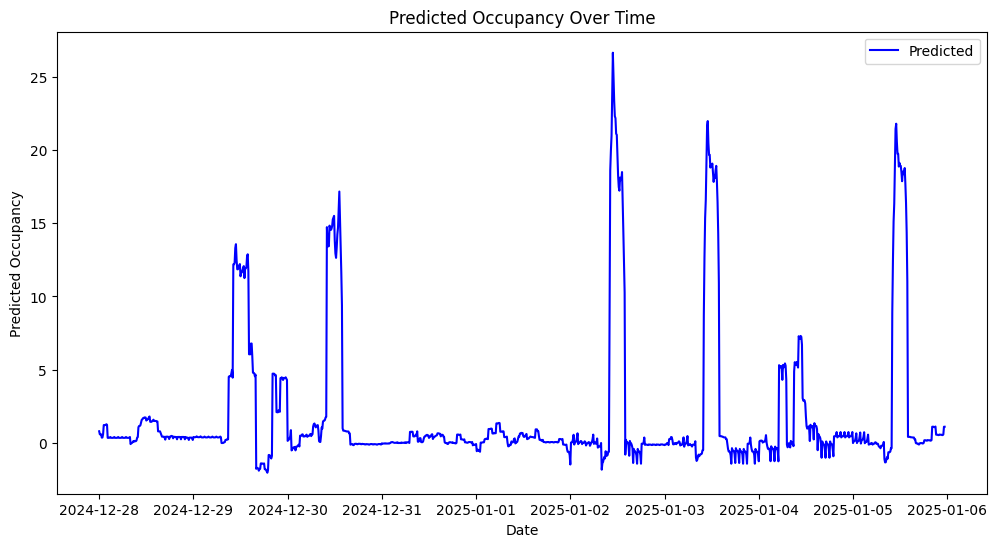

In [46]:

# Separate features (X) and target (y) for model training
X_train = train_data.drop(columns=['y'])  # Keep 'ds' but drop 'y'
y_train = train_data['y']

X_test = test_data.copy()  # Keep 'ds' in the test data for plotting

# Instantiate the XGBoost regressor
model = XGBRegressor(
    n_estimators=100,      # Number of trees
    learning_rate=0.1,     # Step size shrinkage
    max_depth=5,           # Maximum tree depth
    random_state=42        # Seed for reproducibility
)

# Train the model
model.fit(X_train.drop(columns=['ds']), y_train)  # Exclude 'ds' when training the model

# Make predictions and store them in the test data
test_data['y_pred'] = model.predict(X_test.drop(columns=['ds']))

# Print Mean Absolute Error for training set
y_pred_train = model.predict(X_train.drop(columns=['ds']))
train_mae = mean_absolute_error(y_train, y_pred_train)
print(f"Train Mean Absolute Error (MAE): {train_mae}")

# Plot the predictions using the retained 'ds' column
plt.figure(figsize=(12, 6))
plt.plot(test_data['ds'], test_data['y_pred'], label="Predicted", color="blue")
plt.xlabel("Date")
plt.ylabel("Predicted Occupancy")
plt.title("Predicted Occupancy Over Time")
plt.legend()
plt.show()


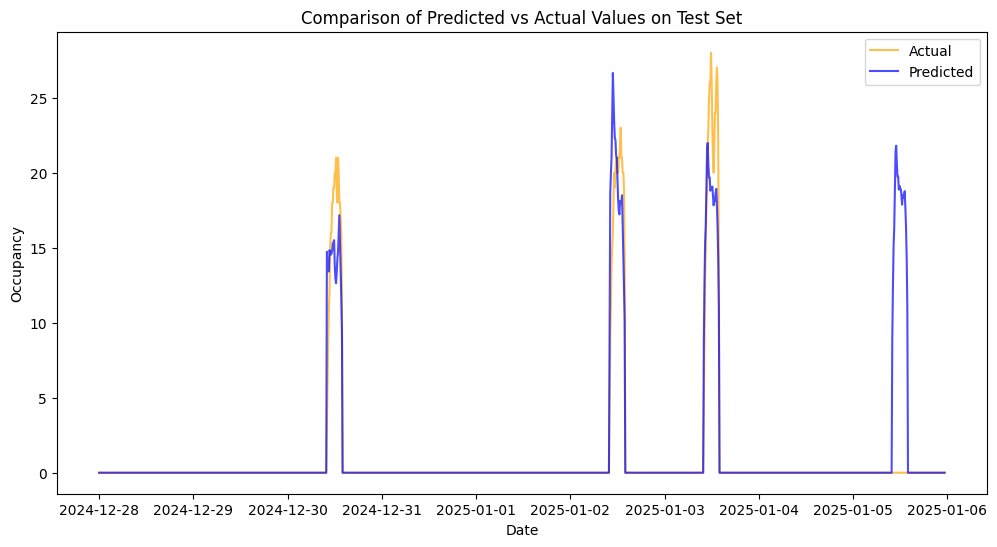

Test Mean Absolute Error (MAE): 0.5738807916641235
Test Root Mean Squared Error (RMSE): 2.722159954794818


In [47]:
# Make predictions
test_data['y_pred'] = model.predict(X_test.drop(columns=['ds']))

# Set predictions to 0 where 'is_open' is 0
test_data.loc[test_data['is_open'] == 0, 'y_pred'] = 0

# Include actual values for comparison
test_data['y_actual'] = df_test['KTH Library'].values

# Plot the predictions and actual values
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(test_data['ds'], test_data['y_actual'], label="Actual", color="orange", alpha=0.7)

# Plot predicted values
plt.plot(test_data['ds'], test_data['y_pred'], label="Predicted", color="blue", alpha=0.7)

# Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Occupancy")
plt.title("Comparison of Predicted vs Actual Values on Test Set")
plt.legend()

# Display the plot
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE and MSE
test_mae = mean_absolute_error(test_data['y_actual'], test_data['y_pred'])
test_mse = mean_squared_error(test_data['y_actual'], test_data['y_pred'])

# Calculate RMSE manually
test_rmse = np.sqrt(test_mse)

print(f"Test Mean Absolute Error (MAE): {test_mae}")
print(f"Test Root Mean Squared Error (RMSE): {test_rmse}")



## 2. Inference Future


In [48]:
import pandas as pd

# Load the CSV file from the GitHub URL
url = "https://raw.githubusercontent.com/davidenascivera/KTH_seat_predictor/main/merged_future.csv"
df_future = pd.read_csv(url)

# Make a copy of the DataFrame
df = df_future.copy()

df.tail()

,index,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,day,opening_hour,closing_hour,is_open
149,2025-01-03 21:30:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,-7.150000,0.0,21.100000,324.500000,Friday,10,14,1
150,2025-01-03 21:40:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,-7.200000,0.0,20.800000,322.000000,Friday,10,14,1
151,2025-01-03 21:50:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,-7.250000,0.0,20.500000,319.500000,Friday,10,14,1
152,2025-01-03 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,-7.300000,0.0,20.200000,317.000000,Friday,10,14,1
153,2025-01-03 22:10:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,-7.333333,0.0,20.016667,315.666667,Friday,10,14,1


In [49]:
# Convert 'index' to datetime
df['index'] = pd.to_datetime(df['index'], errors='coerce')

# Check for any invalid datetime values
if df['index'].isna().any():
    print("Some dates in 'index' could not be converted to datetime format.")

# Set the 'index' column as the index
df.set_index('index', inplace=True)

# Confirm the index type
print(type(df.index))
# Define the mapping
event_mapping = {
    'Normal': 0,
    'Holyday': 1,
    'Re-exam': 2,
    'Self-study': 3
}

df['Event'] = df['Event'].map(event_mapping)


# Calculate the opening and closing times as datetime
df['opening_time'] = df.index.normalize() + pd.to_timedelta(df['opening_hour'], unit='h')
df['closing_time'] = df.index.normalize() + pd.to_timedelta(df['closing_hour'], unit='h')

# Calculate time until open and close
df['time_until_open'] = (df['opening_time'] - df.index).dt.total_seconds() / 60
df['time_until_close'] = (df['closing_time'] - df.index).dt.total_seconds() / 60

# Ensure values make sense
df['time_until_open'] = df['time_until_open'].apply(lambda x: max(x, 0))
df['time_until_close'] = df['time_until_close'].apply(lambda x: max(x, 0))

# Drop temporary columns
df.drop(['opening_time', 'closing_time'], axis=1, inplace=True)

##########
# Ensure the index is a datetime object
df.index = pd.to_datetime(df.index)

# Extract the hour from the index
df['hour'] = df.index.hour

# Update the 'is_open' column
df['is_open'] = ((df['hour'] >= df['opening_hour']) & (df['hour'] < df['closing_hour'])).astype(int)

# Drop the temporary 'hour' column if not needed afterward
df.drop(columns=['hour'], inplace=True)
##########

df_tomorrow = df.copy()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [50]:
df_tomorrow.tail()

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,day,opening_hour,closing_hour,is_open,time_until_open,time_until_close
index,,,,,,,,,,,,,,,,,,,,
2025-01-03 21:30:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,1,-7.150000,0.0,21.100000,324.500000,Friday,10,14,0,0.0,0.0
2025-01-03 21:40:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,1,-7.200000,0.0,20.800000,322.000000,Friday,10,14,0,0.0,0.0
2025-01-03 21:50:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,1,-7.250000,0.0,20.500000,319.500000,Friday,10,14,0,0.0,0.0
2025-01-03 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,1,-7.300000,0.0,20.200000,317.000000,Friday,10,14,0,0.0,0.0
2025-01-03 22:10:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,1,-7.333333,0.0,20.016667,315.666667,Friday,10,14,0,0.0,0.0


In [51]:
df_tomorrow = df_tomorrow.reset_index()[['index',
                                   'Day of Week', 'Days Until Exam','Event', 'temperature_2m', 'precipitation', 'wind_speed_10m',
                                   'time_until_open', 'time_until_close','is_open',]].rename(columns={'index': 'ds'})  # Test needs only `ds` initially

# Convert 'ds' column to datetime if it's not already
df_tomorrow['ds'] = pd.to_datetime(df_tomorrow['ds'])

# Extract hour and minute from the 'ds' column
df_tomorrow['hour'] = df_tomorrow['ds'].dt.hour
df_tomorrow['minute'] = df_tomorrow['ds'].dt.minute

df_tomorrow

,ds,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,time_until_open,time_until_close,is_open,hour,minute
0,2025-01-02 20:40:00,4,5,1,-4.666667,0.0,15.366667,0.0,0.0,0,20,40
1,2025-01-02 20:50:00,4,5,1,-4.683333,0.0,15.433333,0.0,0.0,0,20,50
2,2025-01-02 21:00:00,4,5,1,-4.700000,0.0,15.500000,0.0,0.0,0,21,0
3,2025-01-02 21:10:00,4,5,1,-4.716667,0.0,15.383333,0.0,0.0,0,21,10
4,2025-01-02 21:20:00,4,5,1,-4.733333,0.0,15.266667,0.0,0.0,0,21,20
...,...,...,...,...,...,...,...,...,...,...,...,...
149,2025-01-03 21:30:00,4,5,1,-7.150000,0.0,21.100000,0.0,0.0,0,21,30
150,2025-01-03 21:40:00,4,5,1,-7.200000,0.0,20.800000,0.0,0.0,0,21,40
151,2025-01-03 21:50:00,4,5,1,-7.250000,0.0,20.500000,0.0,0.0,0,21,50
152,2025-01-03 22:00:00,4,5,1,-7.300000,0.0,20.200000,0.0,0.0,0,22,0


In [52]:
# Make predictions and store them in the df_tomorrow dataframe
df_tomorrow['y_pred'] = model.predict(df_tomorrow.drop(columns=['ds']))


In [53]:
df_tomorrow

,ds,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,time_until_open,time_until_close,is_open,hour,minute,y_pred
0,2025-01-02 20:40:00,4,5,1,-4.666667,0.0,15.366667,0.0,0.0,0,20,40,-0.038240
1,2025-01-02 20:50:00,4,5,1,-4.683333,0.0,15.433333,0.0,0.0,0,20,50,0.290294
2,2025-01-02 21:00:00,4,5,1,-4.700000,0.0,15.500000,0.0,0.0,0,21,0,-0.211827
3,2025-01-02 21:10:00,4,5,1,-4.716667,0.0,15.383333,0.0,0.0,0,21,10,-0.063650
4,2025-01-02 21:20:00,4,5,1,-4.733333,0.0,15.266667,0.0,0.0,0,21,20,-0.063650
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,2025-01-03 21:30:00,4,5,1,-7.150000,0.0,21.100000,0.0,0.0,0,21,30,-0.354796
150,2025-01-03 21:40:00,4,5,1,-7.200000,0.0,20.800000,0.0,0.0,0,21,40,-1.215109
151,2025-01-03 21:50:00,4,5,1,-7.250000,0.0,20.500000,0.0,0.0,0,21,50,-1.390914
152,2025-01-03 22:00:00,4,5,1,-7.300000,0.0,20.200000,0.0,0.0,0,22,0,-1.506720


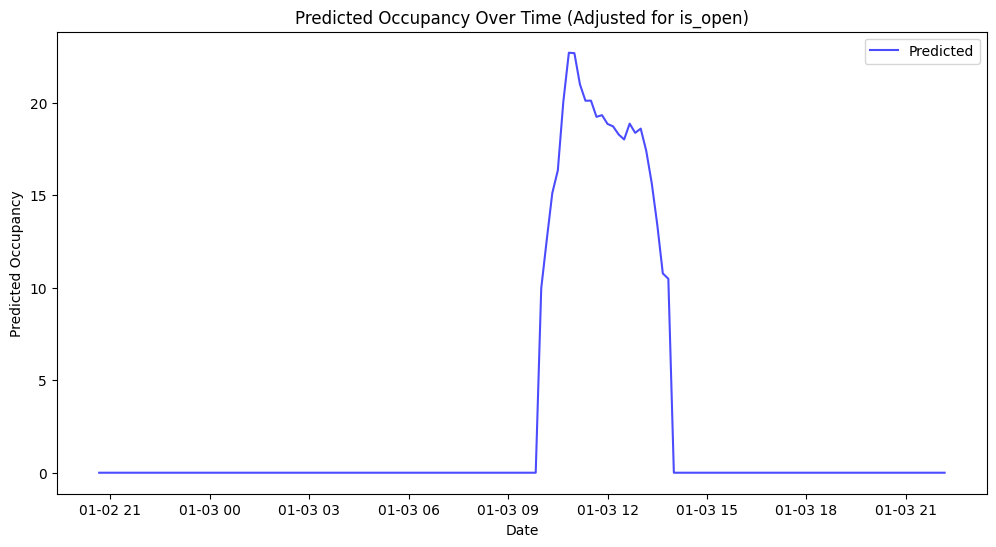

In [54]:
import matplotlib.pyplot as plt

# Ensure y_pred is correctly updated before plotting
df_prova = df_tomorrow.copy()
df_prova.loc[df_prova['is_open'] == 0, 'y_pred'] = 0

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(df_prova['ds'], df_prova['y_pred'], label="Predicted", color="blue", alpha=0.7)

# Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Predicted Occupancy")
plt.title("Predicted Occupancy Over Time (Adjusted for is_open)")
plt.legend()

# Show the plot
plt.show()


## 3. Prophet Training


In [55]:
df = df_bk.copy()

In [56]:
split_date = '2024-12-26'

# Split the dataset
df_train = df[df.index < split_date].copy()
df_test = df[df.index >= split_date].copy()

In [57]:
df_train.index = pd.to_datetime(df_train.index)
df_test.index = pd.to_datetime(df_test.index)

In [58]:
# Select the column to predict, e.g., 'KTH Library'
train_data = df_train.reset_index()[['index', 'KTH Library',
                                     'Day of Week', 'Days Until Exam','Event', 'temperature_2m', 'precipitation', 'wind_speed_10m',
                                     'time_until_open', 'time_until_close','is_open']].rename(columns={'index': 'ds', 'KTH Library': 'y'})

test_data = df_test.reset_index()[['index',
                                   'Day of Week', 'Days Until Exam','Event', 'temperature_2m', 'precipitation', 'wind_speed_10m',
                                   'time_until_open', 'time_until_close','is_open',]].rename(columns={'index': 'ds'})  # Test needs only `ds` initially

train_data

,ds,y,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,time_until_open,time_until_close,is_open
0,2024-12-09 18:10:00,34,1,29,0,-0.4,0.0,6.3,0.0,170.0,1
1,2024-12-09 18:20:00,29,1,29,0,-0.4,0.0,6.3,0.0,160.0,1
2,2024-12-09 18:30:00,28,1,29,0,-0.4,0.0,6.3,0.0,150.0,1
3,2024-12-09 18:40:00,24,1,29,0,-0.4,0.0,6.3,0.0,140.0,1
4,2024-12-09 18:50:00,22,1,29,0,-0.4,0.0,6.3,0.0,130.0,1
...,...,...,...,...,...,...,...,...,...,...,...
2334,2024-12-25 23:10:00,0,3,13,1,6.6,0.0,18.0,0.0,0.0,0
2335,2024-12-25 23:20:00,0,3,13,1,6.6,0.0,18.0,0.0,0.0,0
2336,2024-12-25 23:30:00,0,3,13,1,6.6,0.0,18.0,0.0,0.0,0
2337,2024-12-25 23:40:00,0,3,13,1,6.6,0.0,18.0,0.0,0.0,0


In [59]:
train_data.columns

Index(['ds', 'y', 'Day of Week', 'Days Until Exam', 'Event', 'temperature_2m',
       'precipitation', 'wind_speed_10m', 'time_until_open',
       'time_until_close', 'is_open'],
      dtype='object')

In [60]:
from prophet import Prophet

# Initialize Prophet model
model = Prophet(growth='logistic')

# Add 'is_open' as an additional regressor with an increased prior scale
model.add_regressor('is_open', prior_scale=50.0, standardize=False)
model.add_regressor('time_until_open', prior_scale=40.0, standardize=False)
model.add_regressor('time_until_close', prior_scale=40.0, standardize=False)
model.add_regressor('Day of Week')
model.add_regressor('Days Until Exam')
model.add_regressor('Event')  # Ensure 'Event' is encoded if it's categorical
model.add_regressor('temperature_2m')
model.add_regressor('precipitation')
model.add_regressor('wind_speed_10m')



# Set capacity and floor
train_data['cap'] = 100
train_data['floor'] = 0

# Fit the model on the training data
model.fit(train_data)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuahn53iu/arnac5s4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuahn53iu/ukxn1drd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4449', 'data', 'file=/tmp/tmpuahn53iu/arnac5s4.json', 'init=/tmp/tmpuahn53iu/ukxn1drd.json', 'output', 'file=/tmp/tmpuahn53iu/prophet_modelkmlg_yiz/prophet_model-20250107232347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:23:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:23:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [61]:
# Prepare future dataframe with cap and floor
test_data['cap'] = 100
test_data['floor'] = 0

# Make predictions
forecast = model.predict(test_data)

# Clip predictions to be within 0 and 100
forecast['yhat'] = forecast['yhat'].clip(lower=0, upper=100)
forecast.loc[forecast['is_open'] == 0, 'yhat'] = 0

# View the forecast
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]  # yhat: predicted value
print(predictions)


                      ds  yhat  yhat_lower  yhat_upper
0    2024-12-26 00:00:00   0.0  -16.366366    8.566450
1    2024-12-26 00:10:00   0.0  -17.056606    8.676462
2    2024-12-26 00:20:00   0.0  -16.826519    7.613044
3    2024-12-26 00:30:00   0.0  -16.478979    8.583141
4    2024-12-26 00:40:00   0.0  -18.177825    7.984392
...                  ...   ...         ...         ...
1576 2025-01-05 22:40:00   0.0  -23.562258    0.815300
1577 2025-01-05 22:50:00   0.0  -23.932459    0.884301
1578 2025-01-05 23:00:00   0.0  -23.376290    2.064522
1579 2025-01-05 23:10:00   0.0  -23.110873    2.345945
1580 2025-01-05 23:20:00   0.0  -22.535719    2.363640

[1581 rows x 4 columns]


In [62]:
predictions.columns

Index(['ds', 'yhat', 'yhat_lower', 'yhat_upper'], dtype='object')

In [63]:
# Merge predictions with actual values
test_actuals = df_test.reset_index()[['index', 'KTH Library']].rename(columns={'index': 'ds', 'KTH Library': 'y_actual'})
results = predictions.merge(test_actuals, on='ds', how='left')

# Calculate Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(results['y_actual'], results['yhat'])
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 0.9256937646436144


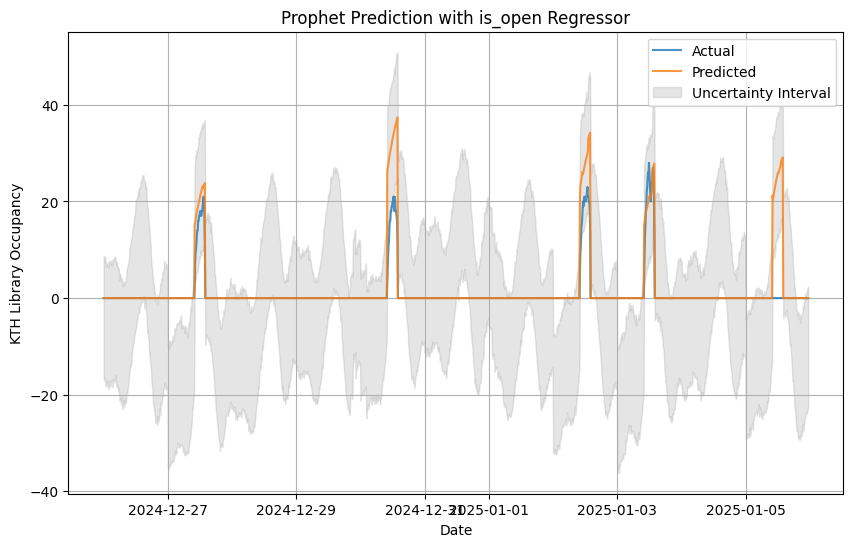

In [64]:
import matplotlib.pyplot as plt

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(results['ds'], results['y_actual'], label='Actual', alpha=0.8)
plt.plot(results['ds'], results['yhat'], label='Predicted', alpha=0.8)
plt.fill_between(results['ds'], results['yhat_lower'], results['yhat_upper'], color='gray', alpha=0.2, label='Uncertainty Interval')
plt.legend()
plt.title('Prophet Prediction with is_open Regressor')
plt.xlabel('Date')
plt.ylabel('KTH Library Occupancy')
plt.grid()
plt.show()


# 3.Prophet NextDay

In [65]:
import pandas as pd

# Load the CSV file from the GitHub URL
url = "https://raw.githubusercontent.com/davidenascivera/KTH_seat_predictor/main/merged_future.csv"
df_future = pd.read_csv(url)

# Make a copy of the DataFrame
df = df_future.copy()

df.tail()

,index,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,day,opening_hour,closing_hour,is_open
149,2025-01-03 21:30:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,-7.150000,0.0,21.100000,324.500000,Friday,10,14,1
150,2025-01-03 21:40:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,-7.200000,0.0,20.800000,322.000000,Friday,10,14,1
151,2025-01-03 21:50:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,-7.250000,0.0,20.500000,319.500000,Friday,10,14,1
152,2025-01-03 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,-7.300000,0.0,20.200000,317.000000,Friday,10,14,1
153,2025-01-03 22:10:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,-7.333333,0.0,20.016667,315.666667,Friday,10,14,1


In [66]:
import pandas as pd



# Check if the 'index' column exists
if 'index' not in df_future.columns:
    print("The column 'index' does not exist in the CSV file. Please check the file.")
else:
    # Convert 'index' to datetime
    df_future['index'] = pd.to_datetime(df_future['index'], errors='coerce')

    # Check for any invalid datetime values
    if df_future['index'].isna().any():
        print("Some dates in 'index' could not be converted to datetime format.")

    # Set the 'index' column as the DataFrame index
    df_future.set_index('index', inplace=True)

    # Confirm the index type
    print(f"Index type: {type(df_future.index)}")

    # Proceed with further processing
    df = df_future.copy()
    print("DataFrame is ready for further processing.")


Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DataFrame is ready for further processing.


In [67]:
# Confirm the index type
print(type(df.index))
# Define the mapping
event_mapping = {
    'Normal': 0,
    'Holyday': 1,
    'Re-exam': 2,
    'Self-study': 3
}

df['Event'] = df['Event'].map(event_mapping)


# Calculate the opening and closing times as datetime
df['opening_time'] = df.index.normalize() + pd.to_timedelta(df['opening_hour'], unit='h')
df['closing_time'] = df.index.normalize() + pd.to_timedelta(df['closing_hour'], unit='h')

# Calculate time until open and close
df['time_until_open'] = (df['opening_time'] - df.index).dt.total_seconds() / 60
df['time_until_close'] = (df['closing_time'] - df.index).dt.total_seconds() / 60

# Ensure values make sense
df['time_until_open'] = df['time_until_open'].apply(lambda x: max(x, 0))
df['time_until_close'] = df['time_until_close'].apply(lambda x: max(x, 0))

# Drop temporary columns
df.drop(['opening_time', 'closing_time'], axis=1, inplace=True)

##########
# Ensure the index is a datetime object
df.index = pd.to_datetime(df.index)

# Extract the hour from the index
df['hour'] = df.index.hour

# Update the 'is_open' column
df['is_open'] = ((df['hour'] >= df['opening_hour']) & (df['hour'] < df['closing_hour'])).astype(int)

# Drop the temporary 'hour' column if not needed afterward
df.drop(columns=['hour'], inplace=True)
##########

df_tomorrow = df.copy()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [68]:
df_tomorrow = df.copy()

In [69]:
df_tomorrow = df_tomorrow.reset_index()[['index',
                                   'Day of Week', 'Days Until Exam','Event', 'temperature_2m', 'precipitation', 'wind_speed_10m',
                                   'time_until_open', 'time_until_close','is_open',]].rename(columns={'index': 'ds'})  # Test needs only `ds` initially

df_tomorrow

,ds,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,time_until_open,time_until_close,is_open
0,2025-01-02 20:40:00,4,5,1,-4.666667,0.0,15.366667,0.0,0.0,0
1,2025-01-02 20:50:00,4,5,1,-4.683333,0.0,15.433333,0.0,0.0,0
2,2025-01-02 21:00:00,4,5,1,-4.700000,0.0,15.500000,0.0,0.0,0
3,2025-01-02 21:10:00,4,5,1,-4.716667,0.0,15.383333,0.0,0.0,0
4,2025-01-02 21:20:00,4,5,1,-4.733333,0.0,15.266667,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
149,2025-01-03 21:30:00,4,5,1,-7.150000,0.0,21.100000,0.0,0.0,0
150,2025-01-03 21:40:00,4,5,1,-7.200000,0.0,20.800000,0.0,0.0,0
151,2025-01-03 21:50:00,4,5,1,-7.250000,0.0,20.500000,0.0,0.0,0
152,2025-01-03 22:00:00,4,5,1,-7.300000,0.0,20.200000,0.0,0.0,0


In [70]:
# Prepare future dataframe with cap and floor
df_tomorrow['cap'] = 100
df_tomorrow['floor'] = 0

# Make predictions
forecast = model.predict(df_tomorrow)

# Clip predictions to be within 0 and 100
forecast['yhat'] = forecast['yhat'].clip(lower=0, upper=100)
forecast.loc[forecast['is_open'] == 0, 'yhat'] = 0

# View the forecast
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]  # yhat: predicted value
print(predictions)


                     ds  yhat  yhat_lower  yhat_upper
0   2025-01-02 20:40:00   0.0  -22.546124    2.322892
1   2025-01-02 20:50:00   0.0  -21.352507    3.135802
2   2025-01-02 21:00:00   0.0  -21.819078    3.027261
3   2025-01-02 21:10:00   0.0  -21.056071    2.827576
4   2025-01-02 21:20:00   0.0  -20.779292    4.876889
..                  ...   ...         ...         ...
149 2025-01-03 21:30:00   0.0  -18.262263    7.386321
150 2025-01-03 21:40:00   0.0  -17.264046    8.274440
151 2025-01-03 21:50:00   0.0  -17.397336    7.723647
152 2025-01-03 22:00:00   0.0  -17.104235    7.882116
153 2025-01-03 22:10:00   0.0  -16.453494    8.781998

[154 rows x 4 columns]


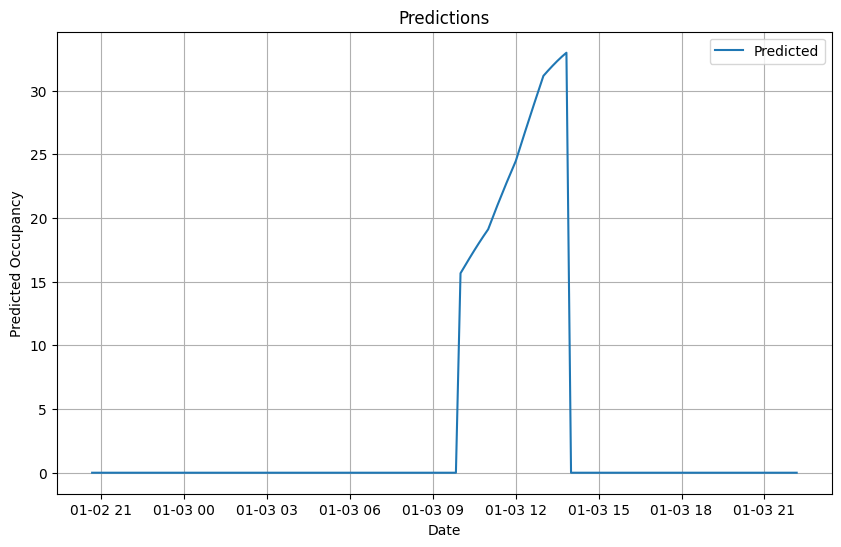

In [71]:
# prompt: plot predictions with ds on x and yhat on y

import matplotlib.pyplot as plt

# Assuming 'results' DataFrame from the previous code is available

plt.figure(figsize=(10, 6))
plt.plot(predictions['ds'], predictions['yhat'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Occupancy')
plt.title('Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
predictions.to_csv('predictions_prophet_ButtaVia.csv', index=False)